In [14]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'stixgeneral'
rcParams['mathtext.fontset'] = 'stix'
from pycbc import conversions, cosmology
from pycbc.distributions import Uniform, Gaussian

## Uniform Lambda Priors

In [2]:
from pycbc.conversions import primary_mass, secondary_mass
labels = ['lambda_s', 'lambda1', 'lambda2', 'lambda_tilde', 'mass1', 'mass2', 'radius', 'mchirp']
samples_prior_unilam = {l: [] for l in labels}

dist_l = Uniform(lambda_s=(0., 5000.))
dist_m = Uniform(mass1=(1.0, 2.0), mass2=(1.0, 2.0))
for (l,), (m1, m2) in zip(dist_l.rvs(size=1000000), dist_m.rvs(size=1000000)):
    m1 = primary_mass(m1, m2)
    m2 = secondary_mass(m1, m2)
    #if m1 < m2:
    #    continue
    # apply mchirp
    mchirp = conversions.mchirp_from_mass1_mass2(m1, m2)
    if not 1.1876 < mchirp < 1.2076:
        continue

    # calculate component lambdas from lambda_symmetric
    l1 = l*(m2/m1)**3
    l2 = l*(m1/m2)**3
    # calculate lambda_tilde from constrained lambdas
    lt = conversions.lambda_tilde(m1, m2, l1, l2)

    # apply lambda_tilde cut
    if lt >= 1300:
        continue
        
    r = 11.2*(mchirp/(1+cosmology.redshift(40.7)))*((lt)/800)**(1./6.)
    #print(r)
    # store samples
    samples_prior_unilam['mass1'].append(m1)
    samples_prior_unilam['mass2'].append(m2)
    samples_prior_unilam['mchirp'].append(mchirp)
    samples_prior_unilam['radius'].append(r)
    samples_prior_unilam['lambda_s'].append(l)
    samples_prior_unilam['lambda1'].append(l1)
    samples_prior_unilam['lambda2'].append(l2)
    samples_prior_unilam['lambda_tilde'].append(lt)

## Prior from EOS data

In [4]:
import pycbc.cosmology
from pycbc.conversions import primary_mass, secondary_mass
import numpy

labels = ['lambda1', 'lambda2', 'lambda_tilde', 'mass1', 'mass2', 'radius', 'mchirp', 'eos']
samples_prior_rec2nsat = {l: [] for l in labels}
distance = 40.7

dist_eos = Uniform(eos=(1, 2000.9))
dist_m = Uniform(mass1=(1.0, 2.0), mass2=(1.0, 2.0))
for (e,), (m1, m2) in zip(dist_eos.rvs(size=1000000), dist_m.rvs(size=1000000)):
    #if m1 < m2:
    #    continue
    m1p = primary_mass(m1, m2)
    m2s = secondary_mass(m1, m2)
    # apply mchirp
    mchirp = conversions.mchirp_from_mass1_mass2(m1p, m2s)
    if not 1.1876 < mchirp < 1.2076:
        continue

    e = int(e)
    
    MRLname = 'cs3MRL_2/'
    
    tov_file = '/Users/brendanking/Documents/LANL_Project_eos/' + MRLname + str(e) + '.dat'
    data = numpy.loadtxt(tov_file)
    mass_from_file = data[:, 0]
    lambda_from_file = data[:, 2]
    
    m1_src = m1p/(1.0 + pycbc.cosmology.redshift(distance))
    
    l1 = numpy.interp(m1_src, mass_from_file, lambda_from_file)
    
    m2_src = m2s/(1.0 + pycbc.cosmology.redshift(distance))
    l2 = numpy.interp(m2_src, mass_from_file, lambda_from_file)
    
    
    lt = conversions.lambda_tilde(m1_src, m2_src, l1, l2)

    samples_prior_rec2nsat['mass1'].append(m1)
    samples_prior_rec2nsat['mass2'].append(m2)
    #samples4['mchirp'].append(mchirp)
    #samples4['radius'].append(r)
    #samples4['lambda_s'].append(l)
    samples_prior_rec2nsat['lambda1'].append(l1)
    samples_prior_rec2nsat['lambda2'].append(l2)
    samples_prior_rec2nsat['lambda_tilde'].append(lt)

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
params = ['lambda_s']
ax_labels = [r'$\tilde \Lambda$']
#ax_bounds = [(0, 5000), (0, 5000), (0, 5000), (1.6, 18)]
#for a, p, l, b in zip(ax.flatten(), params, ax_labels, ax_bounds):
#for a, p, l in zip(ax.flatten(), params, ax_labels):
#max_param_val = int(max(samples4[p]))
#num_bins = max_param_val/100 if max_param_val > 2 else 50
num_bins = 25
h = ax.hist(samples_prior_rec2nsat['lambda_tilde'], bins=num_bins)
#ax.set(xlabel=l)
ax.xaxis.label.set_size(16)
plt.tight_layout()

## Posterior

In [10]:
from pycbc.inference.io import loadfile
from pycbc.conversions import lambda_tilde

labels = ['lambda_s', 'lambda1', 'lambda2', 'lambda_tilde', 'mass1', 'mass2', 'radius', 'mchirp']
samples_post_unilam = {l: [] for l in labels}

fp=loadfile('/home/soumi.de/projects/cbc/inference_for_events/GW170817_EOS/temps20_walkers200_runs/symmetric_lambda_common_comp_radius/uniformmass_lambdatilde1300_gooseneckgoodresolution/inference_nindep.hdf')

#parameters = fp['samples'].keys()
#samples = fp.read_samples(parameters, flatten=True)
m1=primary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
m2=secondary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
ls=fp['samples']['lambdasym'][0:8000]
l1=ls*(m2/m1)**3.
l2=ls*(m1/m2)**3.

#m1=samples['mass1']
print((m1))
samples_post_unilam['mass1'] = m1
samples_post_unilam['mass2'] = m2
samples_post_unilam['lambda1'] = l1
samples_post_unilam['lambda2'] = l2
samples_post_unilam['lambda_tilde'] = lambda_tilde(m1,m2,l1,l2)

print(max(samples_post_unilam['lambda_tilde']))

KeyError: "Unable to open object (object 'lambdasym' doesn't exist)"

In [16]:
from pycbc.inference.io import loadfile
from pycbc.conversions import lambda_tilde

labels = ['lambda1', 'lambda2', 'lambda_tilde', 'mass1', 'mass2', 'radius', 'mchirp', 'eos']
samples_post_rec2nsat = {l: [] for l in labels}

fp=loadfile('/Users/brendanking/Documents/LANL_project/data/completed_runs/cs3_run2_oldindex.hdf')

#parameters = fp['samples'].keys()
#samples = fp.read_samples(parameters, flatten=True)
m1=primary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
m2=secondary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
l1=fp['samples']['lambda1'][0:8000]
l2=fp['samples']['lambda2'][0:8000]

#m1=samples['mass1']
print((m1))
samples_post_rec2nsat['mass1'] = m1
samples_post_rec2nsat['mass2'] = m2
samples_post_rec2nsat['lambda1'] = l1
samples_post_rec2nsat['lambda2'] = l2
samples_post_rec2nsat['lambda_tilde'] = lambda_tilde(m1,m2,l1,l2)

print(max(samples_post_rec2nsat['lambda_tilde']))

[1.4328051  1.4539687  1.65433355 ... 1.56403614 1.47346194 1.40474413]
591.2097902913442


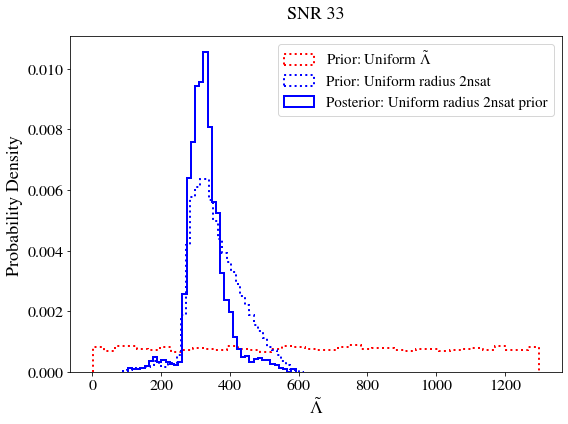

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
params = ['lambda_s']
ax_labels = [r'$\tilde \Lambda$']
#ax_bounds = [(0, 5000), (0, 5000), (0, 5000), (1.6, 18)]
#for a, p, l, b in zip(ax.flatten(), params, ax_labels, ax_bounds):
#for a, p, l in zip(ax.flatten(), params, ax_labels):
#max_param_val = int(max(samples4[p]))
#num_bins = max_param_val/100 if max_param_val > 2 else 50
num_bins = 40
ax.hist(samples_prior_unilam['lambda_tilde'], bins=40, histtype='step',
        facecolor='None', edgecolor='red', ls='dotted', lw=2,
            density=True, label=r"Prior: Uniform $\tilde \Lambda$")
# ax.hist(samples_post_un['lambda_tilde'], bins=num_bins, histtype='step',
#         facecolor='None', edgecolor='red', ls='solid', lw=2,
#         density=True, label=r"Posterior: Uniform $\tilde \Lambda$ prior")
ax.hist(samples_prior_rec2nsat['lambda_tilde'], bins=40, histtype='step',
        facecolor='None', edgecolor='blue', ls='dotted', lw=2, density=True, label=r"Prior: Uniform radius 2nsat")
ax.hist(samples_post_rec2nsat['lambda_tilde'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"Posterior: Uniform radius 2nsat prior")
#ax.set(xlabel=l)
#ax.xaxis.label.set_size(22)
#ax.yaxis.label.set_size(22)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r"$\tilde \Lambda$", fontsize=18)
plt.ylabel(r"Probability Density", fontsize=18)
plt.legend(fontsize=15)
plt.title('SNR 33', fontsize=18, pad=18)
plt.tight_layout()
plt.show()